## Exemplo Real de KNN Basic User-User e Item-Item CF  - Base Banco
- Nesse exemplo a base foi reduzida por conta do custo computacional envolvido principalmente na abordagem de filtragem colaborativa baseada em memória User-User. Assim, optou-se por aplicar uma parte da base (apenas 400 clientes divididos em 5 produtos) com o algoritmo KNN Item-item. Para realizar o user-user, basta alterar a opção no surpride de user-user = False para user-user=True

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
# !conda install -c conda-forge scikit-surprise

In [3]:
data = pd.read_excel("Base_IAP.xlsx")

In [5]:
data = data[(data['Sigla Tipo Pessoa'] == 'PF') & (data[ 'Valor Saldo Cliente Conta Capital Diário'] != 0)]

In [6]:
data['Atividade Econômica'].unique()

array(['PESSOA FISICA'], dtype=object)

In [7]:
data.columns

Index(['Número CPF/CNPJ', 'Atividade Econômica', 'CNAE',
       'Data Início Relacionamento', 'Descrição Categoria Produtor Rural',
       'Escolaridade', 'Estado Civil', 'Idade', 'Profissão',
       'Renda Bruta Mensal', 'Sexo', 'Sigla Tipo Pessoa', 'Tipo Renda',
       'Valor Bem Imóvel', 'Valor Bem Móvel', 'Nome PA',
       'Valor Saldo Cliente Conta Capital Diário',
       'Quantidade Contratos Crédito',
       'Valor Limite Conta Cartão Contratado Diário Cliente Cartão',
       'Quantidade Cota Ativa Cliente Consórcio',
       'Valor Saldo Final Cliente Poupança', 'Valor Saldo Diário Cliente LCA',
       'Valor Saldo Diário Cliente RDC', 'Valor Saldo Diário Cliente LCI',
       'Quantidade Seguro Vigente', 'Valor Contribuição Cliente Previ'],
      dtype='object')

In [8]:
dfprod = data[['Quantidade Contratos Crédito',
       'Valor Limite Conta Cartão Contratado Diário Cliente Cartão',
       'Valor Saldo Final Cliente Poupança',
       'Valor Saldo Diário Cliente RDC',
       'Quantidade Seguro Vigente']]

In [10]:
dfprod.shape[1]

5

In [11]:
dfprod.columns

Index(['Quantidade Contratos Crédito',
       'Valor Limite Conta Cartão Contratado Diário Cliente Cartão',
       'Valor Saldo Final Cliente Poupança', 'Valor Saldo Diário Cliente RDC',
       'Quantidade Seguro Vigente'],
      dtype='object')

In [12]:
dfrename = dfprod.rename(columns={'Quantidade Contratos Crédito':'credito',
                                  'Valor Limite Conta Cartão Contratado Diário Cliente Cartão':'cartao', 
                                  'Valor Saldo Final Cliente Poupança':'poupanca',
                                  'Valor Saldo Diário Cliente RDC':'rdc',
                                  'Quantidade Seguro Vigente':'seguro',                              
                                 }, inplace=False)

In [13]:
dfrename.columns

Index(['credito', 'cartao', 'poupanca', 'rdc', 'seguro'], dtype='object')

In [14]:
for i in dfrename.columns:
    dfrename.loc[dfrename[i]!=0,i] = 1
       

In [15]:
dfrename

,credito,cartao,poupanca,rdc,seguro
5,0,1,0.0,1.0,0
6,0,0,0.0,0.0,0
8,0,0,0.0,0.0,0
9,0,0,0.0,0.0,0
10,0,1,0.0,1.0,0
...,...,...,...,...,...
111392,0,0,0.0,0.0,0
111393,0,0,0.0,0.0,0
111394,0,0,0.0,0.0,0
111395,1,1,0.0,0.0,0


# REORGANIZANDO A TABELA

###### Repetindo cada conjunto de itens 5 vezes

###### Assim, é um produto para cada usuário

In [16]:
index = dfrename.index
columns = dfrename.columns
items = ['credito', 'cartao', 'poupanca','rdc','seguro']*47205
items = pd.Series(items)

lista_index = []
for i in index:
    lista_index.append(i)
    lista_index.append(i)
    lista_index.append(i)
    lista_index.append(i)
    lista_index.append(i)

lista_index = pd.Series(lista_index)

lista_compras = []
for i,j in dfrename.iterrows():
    lista_compras.append(j)
    
lista_series = [] 
for i in lista_compras:
    lista_series.append(pd.Series(i))
        
lista_series = pd.Series(lista_series)

concat_compras = []
for i in lista_series:
    concat_compras.append(i.values)

concat_compras = [l.tolist() for l in concat_compras]
concat_compras = pd.Series(list(concat_compras))

ls = []
  
for i in concat_compras:
    ls.extend(i)

concat_compras = pd.Series(ls)

df = pd.concat([lista_index,items,concat_compras], axis=1)
df.rename(columns={0: "user",1:"item", 2:"raw_ratings"}, inplace=True)
df

,user,item,raw_ratings
0,5,credito,0.0
1,5,cartao,1.0
2,5,poupanca,0.0
3,5,rdc,1.0
4,5,seguro,0.0
...,...,...,...
236020,111397,credito,1.0
236021,111397,cartao,0.0
236022,111397,poupanca,0.0
236023,111397,rdc,0.0


In [18]:
# Diminuindo a base

df = df[:2000]

In [19]:
# Salvando a tabela gerada em um arquivo.csv

# df.to_csv('original_ratings_base_iap')

In [20]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import pandas as pd

from surprise import SVD
from surprise import dataset
from surprise import Reader

# You'll need to create a dummy reader
reader = Reader(line_format='user item rating', rating_scale=(0, 1))

# Also, a dummy Dataset class
class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['user'], df['item'], df['raw_ratings'])]
        self.reader=reader

data = MyDataset(df, reader)

In [22]:
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import KFold

# Load the movielens-100k dataset

# define a cross-validation iterator
kf = KFold(n_splits=3)

sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(sim_options=sim_options)
algo = KNNBasic()
all_pred = []
for trainset, testset in kf.split(data):


    # train and test algorithm.
    algo.fit(trainset)
    pred = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(pred, verbose=True)
    accuracy.mae(pred, verbose=True)
    accuracy.mse(pred, verbose=True)
    all_pred.append(pred)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4029
MAE:  0.3269
MSE: 0.1623
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4118
MAE:  0.3359
MSE: 0.1696
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4102
MAE:  0.3271
MSE: 0.1683


In [23]:
all_pred

[[Prediction(uid=224, iid='cartao', r_ui=1.0, est=0.45, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid=518, iid='rdc', r_ui=0.0, est=0.175, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid=257, iid='cartao', r_ui=0.0, est=0.35, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid=35, iid='seguro', r_ui=1.0, est=0.125, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid=560, iid='seguro', r_ui=0.0, est=0.025, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid=932, iid='rdc', r_ui=0.0, est=0.15, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid=41, iid='credito', r_ui=1.0, est=0.35, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid=904, iid='cartao', r_ui=0.0, est=0.45, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid=413, iid='rdc', r_ui=0.0, est=0.225, details={'actual_k': 40, 'was_impossible': False}),
  Prediction(uid=563, iid='rdc', r

In [24]:
import numpy as np

all_pred = np.array(all_pred)

<ipython-input-24-eaa71ae8baa6>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_pred = np.array(all_pred)


In [25]:
cliente = []
for i in all_pred[0]:
    cliente.append(i[0])
for i in all_pred[1]:
    cliente.append(i[0])
for i in all_pred[2]:
    cliente.append(i[0])
    
produto= []
for i in all_pred[0]:
    produto.append(i[1])
for i in all_pred[1]:
    produto.append(i[1])
for i in all_pred[2]:
    produto.append(i[1])
    
rec= []
for i in all_pred[0]:
    rec.append(i[3])
for i in all_pred[1]:
    rec.append(i[3])
for i in all_pred[2]:
    rec.append(i[3])

In [26]:
print(len(cliente))
print(len(produto))
print(len(rec))

2000
2000
2000


In [27]:
recs = pd.DataFrame({'id_cliente':cliente,'produto':produto,'recomendacao_knn_itemitem':rec})
recs['id_cliente'] = recs['id_cliente'].astype(int)
recs.sort_index()

,id_cliente,produto,recomendacao_knn_itemitem
0,224,cartao,0.450
1,518,rdc,0.175
2,257,cartao,0.350
3,35,seguro,0.125
4,560,seguro,0.025
...,...,...,...
1995,946,cartao,0.500
1996,326,credito,0.125
1997,220,poupanca,0.150
1998,527,poupanca,0.125


# Resumo das recomendações para os 400 clientes

In [28]:
recs = pd.DataFrame({'id_cliente':cliente,'produto':produto,'recomendacao_knn_itemitem':rec})
recs.sort_values(by='recomendacao_knn_itemitem', ascending=False)

,id_cliente,produto,recomendacao_knn_itemitem
1730,497,cartao,0.818182
1353,266,cartao,0.818182
368,791,cartao,0.794521
594,563,cartao,0.794521
251,627,cartao,0.775000
...,...,...,...
825,207,rdc,0.025000
566,456,seguro,0.025000
178,141,seguro,0.025000
1950,136,credito,0.025000


### Recomendações para Crédito Pessoal

In [29]:
rec_credito = recs[recs['produto'] == 'credito'].sort_values(by='recomendacao_knn_itemitem',ascending=False)
rec_credito

,id_cliente,produto,recomendacao_knn_itemitem
1543,478,credito,0.455446
183,563,credito,0.448718
330,791,credito,0.448718
1980,266,credito,0.444444
1372,497,credito,0.444444
...,...,...,...
1260,512,credito,0.050000
981,496,credito,0.050000
1276,463,credito,0.050000
1195,639,credito,0.050000


### Recomendações para Cartão de Crédito

In [30]:
rec_cartao = recs[recs['produto'] == 'cartao'].sort_values(by='recomendacao_knn_itemitem',ascending=False)
rec_cartao

,id_cliente,produto,recomendacao_knn_itemitem
1730,497,cartao,0.818182
1353,266,cartao,0.818182
594,563,cartao,0.794521
368,791,cartao,0.794521
581,713,cartao,0.775000
...,...,...,...
43,800,cartao,0.325000
240,912,cartao,0.260315
513,283,cartao,0.260315
290,701,cartao,0.260315


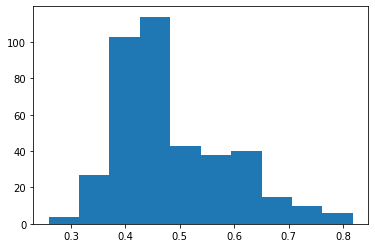

In [38]:
import matplotlib.pyplot as plt
plt.hist(rec_cartao['recomendacao_knn_itemitem']);

### Recomendações para Poupança

In [32]:
rec_poupanca = recs[recs['produto'] == 'poupanca'].sort_values(by='recomendacao_knn_itemitem',ascending=False)
rec_poupanca


,id_cliente,produto,recomendacao_knn_itemitem
836,386,poupanca,0.272727
1091,56,poupanca,0.272727
270,741,poupanca,0.260652
469,701,poupanca,0.260315
493,912,poupanca,0.260315
...,...,...,...
1058,707,poupanca,0.075000
1034,558,poupanca,0.075000
979,945,poupanca,0.075000
898,292,poupanca,0.075000


### Recomendações para Seguros

In [33]:
rec_seguro = recs[recs['produto'] == 'seguro'].sort_values(by='recomendacao_knn_itemitem',ascending=False)
rec_seguro

,id_cliente,produto,recomendacao_knn_itemitem
467,565,seguro,0.375000
1968,551,seguro,0.373832
931,470,seguro,0.372549
443,536,seguro,0.371681
1739,319,seguro,0.359477
...,...,...,...
56,715,seguro,0.025000
547,45,seguro,0.025000
551,825,seguro,0.025000
555,214,seguro,0.025000


### Recomendações para RDC

In [34]:
rec_rdc = recs[recs['produto'] == 'rdc'].sort_values(by='recomendacao_knn_itemitem',ascending=False)
rec_rdc

,id_cliente,produto,recomendacao_knn_itemitem
69,548,rdc,0.325000
731,434,rdc,0.325000
854,895,rdc,0.325000
1098,123,rdc,0.325000
310,235,rdc,0.325000
...,...,...,...
954,445,rdc,0.088663
772,515,rdc,0.078227
944,948,rdc,0.064470
1240,125,rdc,0.025000


In [36]:
#SALVANDO RECOMENDAÇÕES EM XLSX

# recs.to_csv('rec_knn_itemitem.csv')
# recs.to_excel('rec_knn_itemitem.xlsx')
# rec_cartao.to_excel('rec_cartao_knn_itemitem.xlsx')
# rec_poupanca.to_excel('rec_poupanca_knn_itemitem.xlsx')
# rec_seguro.to_excel('rec_seguro_knn_itemitem.xlsx')
# rec_credito.to_excel('rec_credito_knn_itemitem.xlsx')
# rec_rdc.to_excel('rec_rdc_knn_itemitem.xlsx')